## EDA5 - LightGBM Hyperparameter Tuning
#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Data Retrieval](#eda_csv)
#### 3. [Create Pipeline and Tune Using RandomSearch ](#eda_pipe)
#### 4. [Tune Using Optuna](#eda_optuna)


### <a name="eda_import"></a>Installation and Importing of Libraries

In [1]:
!pip install optuna

In [2]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [3]:
!pip install lightgbm==3.3.5

In [4]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (1.0.2)


In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score,\
classification_report, auc, recall_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint
import lightgbm as lgb
import optuna
from lightgbm import LGBMClassifier
import joblib
import warnings

In [7]:
warnings.filterwarnings('ignore')

In [8]:
def makeConfusionMatrixandScore(model,y_actual,X_set,thresh=0.5):
    ###A function for printing out a confusion matric and classification report
    ###to consistantly evaluate model performance
    y_pred_prob = model.predict(X_set)
    y_pred = pd.Series(y_pred_prob).apply(lambda x: 1 if x > thresh else 0)
    
    cm = confusion_matrix(y_actual,np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()    
    
    print(classification_report(y_actual, y_pred))
    

In [9]:
def optimizedf1(y_test, y_pred_proc):
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc,pos_label=1)
    
    fscore = np.nan_to_num((2 * precision * recall) / (precision + recall))
    
    index = np.argmax(fscore)
    
    return thresholds[index]

In [10]:
def plot_roc_and_prc(y_test, y_pred_proc):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proc)
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
    
    
    auc = roc_auc_score(y_test, y_pred_proc)
    
    ap = average_precision_score(y_test, y_pred_proc)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    
    ##plot ROC
    ax1.plot(fpr,tpr)
    ax1.plot([0,1],[0,1], "k-", color = "r",lw=1)
    ax1.annotate(f"AUC: {auc:.2f}",(.75,.25),weight="bold",size=14)
    ax1.set_ylabel('True Positive Rate/ Recall')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_title("ROC Curve")
    
    ##plot Precision-Recall Curve
    ax2.plot(recall,precision)
    ax2.set_ylabel("Precision")
    ax2.set_xlabel("Recall")
    ax2.set_title("Precision-Recall Curve")
    ax2.annotate(f"AP: {ap:.2f}",(.5,.75),weight="bold",size=14)
    
    plt.show()

### <a name= "eda_csv"> </a>  Get Training and Validation Data

In [11]:
X_train = pd.read_csv("/dsa/groups/casestudy2023su/team03/Data4/X_train.csv")
y_train = pd.read_csv("/dsa/groups/casestudy2023su/team03/Data4/y_train.csv")
X_validation = pd.read_csv("/dsa/groups/casestudy2023su/team03/Data4/X_validation.csv")
y_validation = pd.read_csv("/dsa/groups/casestudy2023su/team03/Data4/y_validation.csv")

In [12]:
features = joblib.load("/dsa/groups/casestudy2023su/team03/merged_data/LGBM/features.pkl")

In [13]:
X_train = X_train[features].values
X_validation = X_validation[features].values
y_train = y_train.values.ravel()
y_validation = y_validation.values.ravel()

### <a name= "eda_pipe"> </a> Create Pipeline and Tune Using RandomSearch 

In [13]:
pipe = Pipeline(steps=[("kbest",SelectKBest(mutual_info_classif)),("lgb",LGBMClassifier(objective="binary",n_jobs=-1,scale_pos_weight=2.33))])

In [14]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('kbest',
                 SelectKBest(score_func=<function mutual_info_classif at 0x7f1ca80f19d8>)),
                ('lgb',
                 LGBMClassifier(objective='binary', scale_pos_weight=2.33))])>

In [ ]:
LGBMClassifier()

In [15]:
params = {
    "kbest__k":randint(3,20),
    "lgb__learning_rate":[0.01,0.3],
    "lgb__num_leaves":randint(20,3000),
    "lgb__extra_trees":[True,False],
    "lgb__max_bin":randint(100,300),
    "lgb__feature_fraction":uniform(0.2,0.8)
}

In [22]:
rcv = RandomizedSearchCV(pipe,params,cv=5,n_iter=50,scoring="roc_auc")

In [25]:
rcv.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6698349982333079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698349982333079
[LightGBM] [Warning] feature_fraction is set=0.6698349982333079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698349982333079
[LightGBM] [Warning] feature_fraction is set=0.6698349982333079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698349982333079
[LightGBM] [Warning] feature_fraction is set=0.6698349982333079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698349982333079
[LightGBM] [Warning] feature_fraction is set=0.6698349982333079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698349982333079
[LightGBM] [Warning] feature_fraction is set=0.8904959864128139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8904959864128139
[LightGBM] [Warning] feature_fraction is set=0.8904959864128139, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.683573980913766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.683573980913766
[LightGBM] [Warning] feature_fraction is set=0.8094308040791034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094308040791034
[LightGBM] [Warning] feature_fraction is set=0.8094308040791034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094308040791034
[LightGBM] [Warning] feature_fraction is set=0.8094308040791034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094308040791034
[LightGBM] [Warning] feature_fraction is set=0.8094308040791034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094308040791034
[LightGBM] [Warning] feature_fraction is set=0.8094308040791034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094308040791034
[LightGBM] [Warning] feature_fraction is set=0.7998277406470442, colsample_byt

[LightGBM] [Warning] feature_fraction is set=0.7055053464371226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7055053464371226
[LightGBM] [Warning] feature_fraction is set=0.7055053464371226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7055053464371226
[LightGBM] [Warning] feature_fraction is set=0.3524501987607768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3524501987607768
[LightGBM] [Warning] feature_fraction is set=0.3524501987607768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3524501987607768
[LightGBM] [Warning] feature_fraction is set=0.3524501987607768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3524501987607768
[LightGBM] [Warning] feature_fraction is set=0.3524501987607768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3524501987607768
[LightGBM] [Warning] feature_fraction is set=0.3524501987607768, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.4612570680258128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4612570680258128
[LightGBM] [Warning] feature_fraction is set=0.4612570680258128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4612570680258128
[LightGBM] [Warning] feature_fraction is set=0.4612570680258128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4612570680258128
[LightGBM] [Warning] feature_fraction is set=0.6065911971221689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6065911971221689
[LightGBM] [Warning] feature_fraction is set=0.6065911971221689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6065911971221689
[LightGBM] [Warning] feature_fraction is set=0.6065911971221689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6065911971221689
[LightGBM] [Warning] feature_fraction is set=0.6065911971221689, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.6032982217038831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6032982217038831
[LightGBM] [Warning] feature_fraction is set=0.6032982217038831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6032982217038831
[LightGBM] [Warning] feature_fraction is set=0.6032982217038831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6032982217038831
[LightGBM] [Warning] feature_fraction is set=0.6032982217038831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6032982217038831
[LightGBM] [Warning] feature_fraction is set=0.6032982217038831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6032982217038831
[LightGBM] [Warning] feature_fraction is set=0.3608778235353965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3608778235353965
[LightGBM] [Warning] feature_fraction is set=0.3608778235353965, colsample_b

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('kbest',
                                              SelectKBest(score_func=<function mutual_info_classif at 0x7f1ca80f19d8>)),
                                             ('lgb',
                                              LGBMClassifier(objective='binary',
                                                             scale_pos_weight=2.33))]),
                   n_iter=50,
                   param_distributions={'kbest__k': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1c9c6a9588>,
                                        'lgb__extra_trees': [True, False],
                                        'lgb__feature_fraction': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1c9c6abd30>,
                                        'lgb__learning_rate': [0.01, 0.3],
                                        'lgb__max_bin': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1c9c6ab278>,
        

In [26]:
import joblib
joblib.dump(rcv,"LGBMpipe.pkl")

['LGBMpipe.pkl']

In [ ]:
rcv = joblib.load("LGBMpipe.pkl")

In [27]:
rcv.best_params_

{'kbest__k': 18,
 'lgb__extra_trees': True,
 'lgb__feature_fraction': 0.8332689775663373,
 'lgb__learning_rate': 0.3,
 'lgb__max_bin': 167,
 'lgb__num_leaves': 1044}

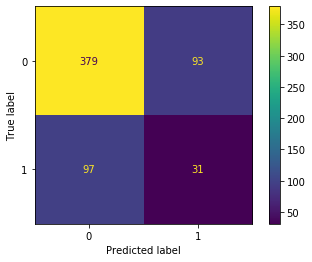

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       472
           1       0.25      0.24      0.25       128

    accuracy                           0.68       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.68      0.68      0.68       600



In [30]:
thresh = optimizedf1(y_validation,rcv.predict(X_validation))
makeConfusionMatrixandScore(rcv,y_validation,X_validation, thresh = thresh)

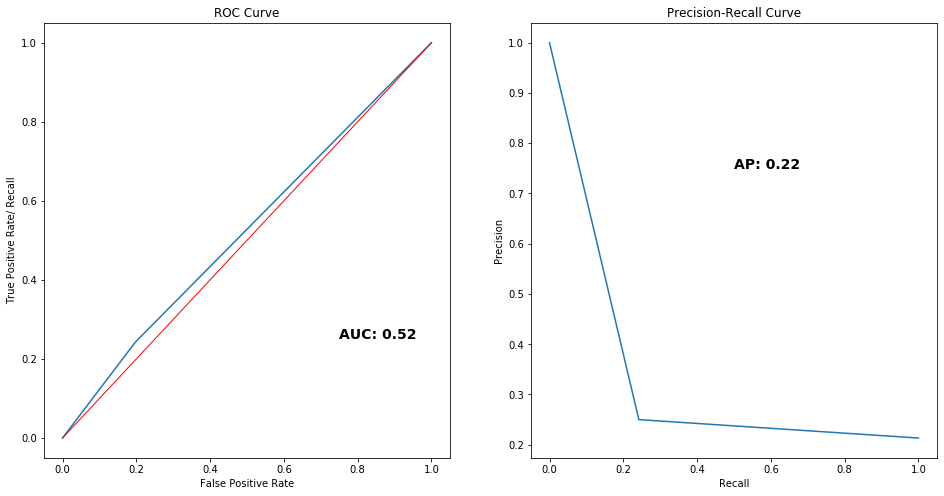

In [31]:
plot_roc_and_prc(y_validation,rcv.predict(X_validation))

### <a name="eda_optuna"> </a> Hyperparameter Tuning Using Optuna

In [48]:

def objective(trial):
        
    
    
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.8),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'verbosity': -1,
        'num_threads':4
        
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_scores = []
        
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        train_data = lgb.Dataset(data=X_train_fold, label=y_train_fold)
        

        bst = lgb.train(param, train_data,verbose_eval=False)
        preds = bst.predict(X_val_fold)
        
        auc = roc_auc_score(y_val_fold, preds)  
        auc_scores.append(auc)
    print(f"Mean Score:{np.mean(auc_scores):.2f} trial scores:")
    print(*auc_scores, sep=",")
    return np.mean(auc_scores)
    

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 

[I 2023-07-15 13:48:20,577] A new study created in memory with name: no-name-0c92f1d9-c36c-42d3-a9ae-8641a1e88fb3
[I 2023-07-15 13:48:27,344] Trial 0 finished with value: 0.9088233190827435 and parameters: {'lambda_l1': 0.0001823151227083342, 'lambda_l2': 8.678448687404686e-07, 'num_leaves': 40, 'feature_fraction': 0.7750579138200193, 'bagging_fraction': 0.7705451755423873, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 0 with value: 0.9088233190827435.


Mean Score:0.91 trial scores:
0.9041584877841445,0.9207931443768971,0.8984390018500589,0.9044672374332456,0.9162587239693707


[I 2023-07-15 13:48:35,461] Trial 1 finished with value: 0.9093273459429122 and parameters: {'lambda_l1': 5.144428289523027, 'lambda_l2': 2.6416083778925876, 'num_leaves': 192, 'feature_fraction': 0.4053697800038945, 'bagging_fraction': 0.82248035297027, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 1 with value: 0.9093273459429122.


Mean Score:0.91 trial scores:
0.9049962169912648,0.9220982382995684,0.8988975483634298,0.9012213557119041,0.9194233703483936


[I 2023-07-15 13:48:51,156] Trial 2 finished with value: 0.9182867978980258 and parameters: {'lambda_l1': 3.3593970067065135e-06, 'lambda_l2': 2.2973341652554997, 'num_leaves': 156, 'feature_fraction': 0.43694128821759676, 'bagging_fraction': 0.9392138210133557, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.92 trial scores:
0.9160877516935357,0.9300822385535326,0.9054300725385311,0.913664490972281,0.9261694357322483


[I 2023-07-15 13:49:06,746] Trial 3 finished with value: 0.9162523406229095 and parameters: {'lambda_l1': 3.528860828831351e-05, 'lambda_l2': 3.896468770790473e-08, 'num_leaves': 240, 'feature_fraction': 0.7508441422348937, 'bagging_fraction': 0.9700197648265579, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.92 trial scores:
0.9115005229193893,0.9291651455267905,0.9004671883515076,0.9135426379588031,0.9265862083580572


[I 2023-07-15 13:49:10,147] Trial 4 finished with value: 0.9036977545442542 and parameters: {'lambda_l1': 0.18159481696311042, 'lambda_l2': 2.487919335774517e-08, 'num_leaves': 20, 'feature_fraction': 0.5098389825975639, 'bagging_fraction': 0.9166543902167038, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.90 trial scores:
0.8994319314155508,0.9146345119742367,0.8945942656994863,0.8995736910513972,0.9102543725805996


[I 2023-07-15 13:49:17,446] Trial 5 finished with value: 0.9076941093621427 and parameters: {'lambda_l1': 8.637313558133482e-08, 'lambda_l2': 0.0038822985104898914, 'num_leaves': 79, 'feature_fraction': 0.40723903272196216, 'bagging_fraction': 0.656675648803049, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.91 trial scores:
0.9052448902927467,0.9181811928911182,0.901437190591331,0.9032769630697071,0.9103303099658105


[I 2023-07-15 13:49:22,460] Trial 6 finished with value: 0.9059422515451836 and parameters: {'lambda_l1': 7.37741932663729, 'lambda_l2': 0.0016843600209177406, 'num_leaves': 200, 'feature_fraction': 0.7561212753449655, 'bagging_fraction': 0.7037451374560919, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.91 trial scores:
0.906047346691146,0.9150736584428112,0.8931180986545187,0.8982315419174366,0.9172406120200051


[I 2023-07-15 13:49:38,060] Trial 7 finished with value: 0.9159493204599588 and parameters: {'lambda_l1': 0.6779152982953104, 'lambda_l2': 1.4419516139534322e-06, 'num_leaves': 144, 'feature_fraction': 0.6056936160195492, 'bagging_fraction': 0.7799103156956828, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.92 trial scores:
0.9158179147068212,0.9207437624446879,0.9044847612648124,0.9130181402051367,0.9256820236783362


[I 2023-07-15 13:49:49,564] Trial 8 finished with value: 0.9126715534328829 and parameters: {'lambda_l1': 2.761281884493614e-08, 'lambda_l2': 0.040869860807183606, 'num_leaves': 251, 'feature_fraction': 0.41298179874576385, 'bagging_fraction': 0.6645220403262733, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.91 trial scores:
0.9085040978185532,0.9222181658492192,0.8987388207241861,0.910837147862451,0.9230595349100054


[I 2023-07-15 13:50:00,064] Trial 9 finished with value: 0.9130553764710028 and parameters: {'lambda_l1': 0.00010238419885688583, 'lambda_l2': 0.08281791024428131, 'num_leaves': 112, 'feature_fraction': 0.4293870179103963, 'bagging_fraction': 0.9100729147928943, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.91 trial scores:
0.9086487163343087,0.9247119534257834,0.9044530157369637,0.9089139894323415,0.9185492074256167


[I 2023-07-15 13:50:05,549] Trial 10 finished with value: 0.9067780632623827 and parameters: {'lambda_l1': 1.318045392573629e-06, 'lambda_l2': 2.9939149117543513, 'num_leaves': 162, 'feature_fraction': 0.5262592677979445, 'bagging_fraction': 0.5339298809432291, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 2 with value: 0.9182867978980258.


Mean Score:0.91 trial scores:
0.8992679128549987,0.9197384873961436,0.8960069416887563,0.9026765279308299,0.9162004464411856


[I 2023-07-15 13:50:25,854] Trial 11 finished with value: 0.9202548545797784 and parameters: {'lambda_l1': 7.50598357662e-06, 'lambda_l2': 4.445160750866582e-05, 'num_leaves': 248, 'feature_fraction': 0.6869826349630017, 'bagging_fraction': 0.9936820375410613, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 11 with value: 0.9202548545797784.


Mean Score:0.92 trial scores:
0.9184792481248093,0.9278265424358344,0.909119608330732,0.9168997767794074,0.9289490972281089


[I 2023-07-15 13:50:47,368] Trial 12 finished with value: 0.9175768402190171 and parameters: {'lambda_l1': 2.2462937608146448e-06, 'lambda_l2': 4.8612190041486916e-05, 'num_leaves': 205, 'feature_fraction': 0.6230173546307289, 'bagging_fraction': 0.9815911951276097, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 11 with value: 0.9202548545797784.


Mean Score:0.92 trial scores:
0.9170630448546673,0.9268671220386272,0.9051320173048398,0.9131876748325846,0.9256343420643666


[I 2023-07-15 13:51:01,146] Trial 13 finished with value: 0.9145126308175604 and parameters: {'lambda_l1': 0.00985355579348487, 'lambda_l2': 2.525637127138237e-05, 'num_leaves': 101, 'feature_fraction': 0.674549198768038, 'bagging_fraction': 0.9967840274676245, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 11 with value: 0.9202548545797784.


Mean Score:0.91 trial scores:
0.9125816345066833,0.9219853653116618,0.899401949528138,0.9112450905597469,0.9273491141815716


[I 2023-07-15 13:51:19,353] Trial 14 finished with value: 0.9216614797813822 and parameters: {'lambda_l1': 5.510710967088529e-06, 'lambda_l2': 0.0001290090066175564, 'num_leaves': 165, 'feature_fraction': 0.6815674480873333, 'bagging_fraction': 0.8625258008349302, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 14 with value: 0.9216614797813822.


Mean Score:0.92 trial scores:
0.9224245117802363,0.9296430920849581,0.9039556691339995,0.9194710519623633,0.9328130739453533


[I 2023-07-15 13:51:53,650] Trial 15 finished with value: 0.9239116673370378 and parameters: {'lambda_l1': 0.0020509726567226774, 'lambda_l2': 0.00013128906058866555, 'num_leaves': 225, 'feature_fraction': 0.6915173412664041, 'bagging_fraction': 0.8581350988668321, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 15 with value: 0.9239116673370378.


Mean Score:0.92 trial scores:
0.9191159223222207,0.9310028588611468,0.9153188044634213,0.9197942273459354,0.9343265236924642


[I 2023-07-15 13:52:22,269] Trial 16 finished with value: 0.9220800390312391 and parameters: {'lambda_l1': 0.0016196273523282267, 'lambda_l2': 0.00031686183552936395, 'num_leaves': 183, 'feature_fraction': 0.6970853760877085, 'bagging_fraction': 0.8574985923621379, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 15 with value: 0.9239116673370378.


Mean Score:0.92 trial scores:
0.9196538326552137,0.9296572012084463,0.911946723949708,0.9155399677884207,0.9336024695544065


[I 2023-07-15 13:53:18,844] Trial 17 finished with value: 0.9223433735319523 and parameters: {'lambda_l1': 0.0013142725059975139, 'lambda_l2': 0.0007600488474296333, 'num_leaves': 221, 'feature_fraction': 0.7232919238040633, 'bagging_fraction': 0.8602391938032639, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 15 with value: 0.9239116673370378.


Mean Score:0.92 trial scores:
0.9193751774663188,0.931553114677192,0.9108955942498267,0.9164070667683875,0.9334859144980363


[I 2023-07-15 13:54:04,266] Trial 18 finished with value: 0.9243398145055522 and parameters: {'lambda_l1': 0.002874594857238398, 'lambda_l2': 0.0028653146630632682, 'num_leaves': 221, 'feature_fraction': 0.7946658136127679, 'bagging_fraction': 0.8798348828609295, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 18 with value: 0.9243398145055522.


Mean Score:0.92 trial scores:
0.9241211338797092,0.9303714755850436,0.9146574392999052,0.921102822751547,0.9314462010115565


[I 2023-07-15 14:00:05,661] Trial 19 finished with value: 0.9231835136730726 and parameters: {'lambda_l1': 0.01144619056622563, 'lambda_l2': 0.00935160318016033, 'num_leaves': 220, 'feature_fraction': 0.783753730650165, 'bagging_fraction': 0.7594896831715805, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 18 with value: 0.9243398145055522.


Mean Score:0.92 trial scores:
0.9226238031495091,0.9312815140500414,0.9070261671331495,0.9186198468537199,0.9363662371789437


[I 2023-07-15 14:00:15,461] Trial 20 finished with value: 0.9079143500592863 and parameters: {'lambda_l1': 0.026004486545589095, 'lambda_l2': 0.014590863270891449, 'num_leaves': 67, 'feature_fraction': 0.7839489125311981, 'bagging_fraction': 0.4120865409025207, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 18 with value: 0.9243398145055522.


Mean Score:0.91 trial scores:
0.9008904620561577,0.9176573916816135,0.8922874240091427,0.9096768952558559,0.9190595772936623


In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
train_data = lgb.Dataset(X_train,label=y_train)

param =study.best_trial.params



bst = lgb.train(param, train_data)

In [ ]:
joblib.dump(bst,"LGBMoptuna.pkl")

In [14]:
bst = joblib.load("LGBMoptuna.pkl")

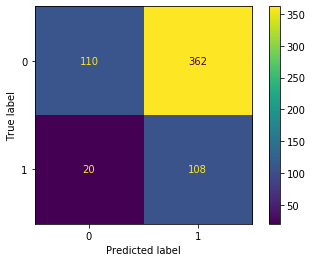

              precision    recall  f1-score   support

           0       0.85      0.23      0.37       472
           1       0.23      0.84      0.36       128

    accuracy                           0.36       600
   macro avg       0.54      0.54      0.36       600
weighted avg       0.71      0.36      0.36       600



In [15]:
thresh = optimizedf1(y_validation,bst.predict(X_validation))
makeConfusionMatrixandScore(bst,y_validation,X_validation, thresh = thresh)

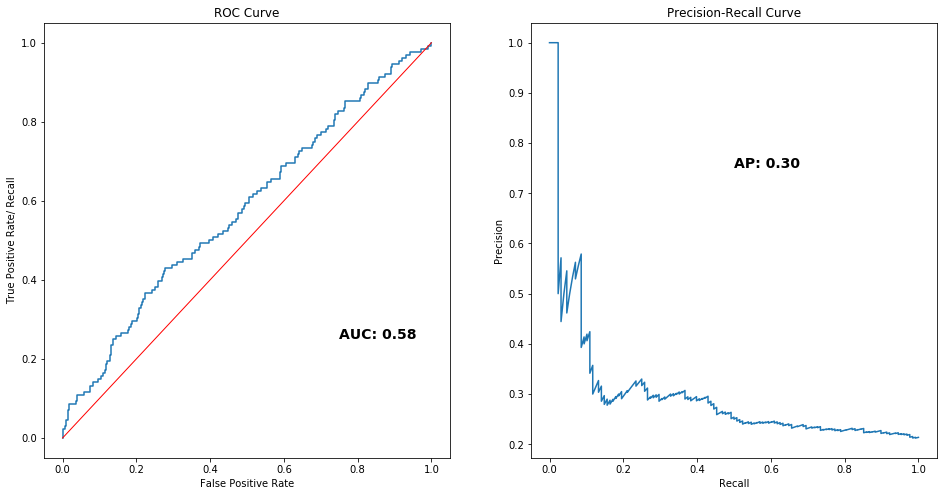

In [16]:
plot_roc_and_prc(y_validation,bst.predict(X_validation))